In [117]:
import os

In PCA, our primary objective is to find the directions in which data exhibits the most significant variation. This approach allows us to represent the data in fewer dimensions without experiencing a considerable loss of information.

## Consider Figure 1 as an example:

### (a) Original Dataset
In the original two-dimensional dataset, the variation along the `x2-axis` is minimal.

### (b) Dimension Reduction
For the dataset depicted in **(a)**, using only the `x1-axis` for representation effectively retains almost all the information.



### **A statistical summary of genetic data from 1,387 Europeans based on principal component axis one (PC1) and axis two (PC2). Small coloured labels represent individuals and large coloured points represent median PC1 and PC2 values for each country. The inset map provides a key to the labels. The PC axes are rotated to emphasize the similarity to the geographic map of Europe**


Novembre J, Johnson T, Bryc K, Kutalik Z, Boyko AR, Auton A, Indap A, King KS, Bergmann S, Nelson MR, Stephens M, Bustamante CD. Genes mirror geography within Europe. Nature. 2008 Nov 6;456(7218):98-101. doi: 10.1038/nature07331. Epub 2008 Aug 31. Erratum in: Nature. 2008 Nov 13;456(7219):274. PMID: 18758442; PMCID: PMC2735096.

In [129]:
### PDB Loader

def apply_mean_coord_on_missing_data(coord_mat,K_mat,w=None):
    if w is None:
        w=np.ones(len(coord_mat[0]))
    coord_mat = coord_mat+(np.ones(np.shape(coord_mat))*(np.sum(coord_mat*w,axis=1)/np.sum(w*K_mat,axis=1))[:,np.newaxis]*(np.ones(np.shape(K_mat))-K_mat))
    return(coord_mat)

def read_pdb_info(pdb_file):
    with open(pdb_file) as f:
        line_1 = f.readline()
        if line_1.split()[0] != 'NUMMDL':#=if there is only 1 model in the pdb
            return(None,None,None)
        else:
            num_mdl = int(line_1.split()[1])
            # if num_mdl<2:
            #     return(None,None,None)
            line_2 = f.readline()
            seq_len=int(line_2.split()[1])
            chains_names = [f.readline().split()[2] for _ in range(num_mdl)]
            return(seq_len,num_mdl,chains_names)

def pdbparser(pdb_file,CA_only=False, output_gaps = False, mean_coords = True, trim_column1=True, output_chains_names=True, output_seqs=False):
    seq_len,num_mdl,chains_names = read_pdb_info(pdb_file)
    if seq_len is None:
       raise TypeError('not a valid pdb multi model')
    if CA_only:
        float_per_res = 3
        at_per_res=1
    else:
        float_per_res = 12
        at_per_res=4
    output = {}
    coords = np.zeros((int(seq_len)*float_per_res,int(num_mdl)))
    gaps = np.zeros((int(seq_len)*float_per_res,int(num_mdl)))
    n_model=0
    for line in open(pdb_file):
        if line[:4] == 'ATOM' or line[:6] == "HETATM":
            liste = [line[:6], line[6:11], line[12:16], line[17:20], line[21], line[22:26], line[30:38], line[38:46], line[46:54]]
            if CA_only and liste[2].strip()!='CA':
                continue
            id_res= int(liste[5])-1
            id_at = int(liste[1])-1
            id_c = (id_res)*float_per_res+(id_at%at_per_res)*3
            c = np.asarray(liste[6:9],dtype=float)
            coords[id_c:id_c+3,n_model] = c
            gaps[id_c:id_c+3,n_model] = 1
        elif line[:5] == 'MODEL':
            n_model = int(line.split()[1])-1
    if trim_column1: #remove the columns containing only one residue
        col_to_keep = np.where(np.sum(gaps,axis=1) > 1)[0]
        gaps = gaps[col_to_keep]
        coords=coords[col_to_keep]
    if mean_coords:
        coords = apply_mean_coord_on_missing_data(coords,gaps)
    if output_chains_names:
        output['chains_names']=chains_names
    if output_gaps:
        output['gaps'] = gaps
    if output_seqs:
        seqs = [''.join(list(a)).replace('-','') for a in aln]
        output['seqs'] = seqs
    output['coords'] = coords.T
    return(output)




# Application to an ensemble of aligned proteins

The coordinates of the ensembles of proteins are the multimodel PDB files.

We load them into matrices of size (number_of_conformations, number_of_atoms_per_conformation*3)



In [203]:
# Inspect the structure of the PDB file, then visualize it using Pymol

struct_name = '1AKEA'
mm = pdbparser(struct_name+'_mm.pdb',CA_only=True, output_gaps = True, mean_coords = True, trim_column1=True, output_chains_names=True, output_seqs=False)
gaps_mm = mm['gaps']
coords_mm = mm['coords']
print(coords_mm.shape)


### What is the % of variance explained by the principal component ?

# Step 0: Center the data
mean_mm = np.mean(coords_mm,1)
centered_mm = coords_mm - np.reshape(mean_mm,(-1,1))
print(centered_mm.shape)
# Step 1: Compute the covariance matrix

cov_matrix =  np.cov(centered_mm)
print(cov_matrix.shape)
# The covariance matrix should be of dimension (n_features, n_features), so here (3*number_of_atoms,3*number_of_atoms)

# Step 2: Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:,sorted_indices]

print(sorted_eigenvalues[0:10]/np.sum(sorted_eigenvalues))  # The proportion of variance explained by the 10 first components

(42, 645)
(42, 645)
(42, 42)
[9.79125412e-01 2.00234179e-02 2.92183138e-04 1.24206518e-04
 1.12330479e-04 5.19386816e-05 3.64215990e-05 3.31391882e-05
 3.10471908e-05 2.14948739e-05]


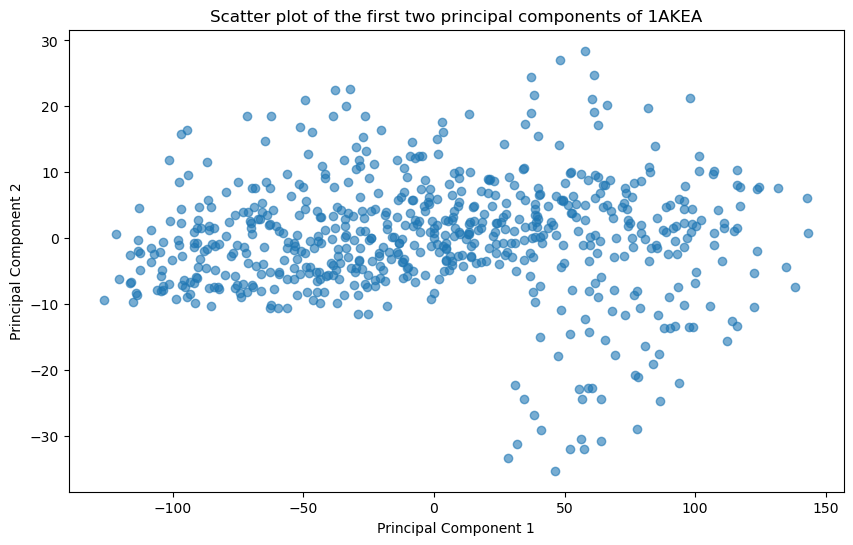

In [160]:
# Observe the PC Plot
# Step 3: Select the first two principal components
top_2_eigenvectors =  sorted_eigenvectors[:,:2]

# Step 4: Project the data onto the first two principal components
pc_scores =  top_2_eigenvectors.T @ coords_mm

plt.figure(figsize=(10, 6))
plt.scatter(pc_scores[0], pc_scores[1], alpha=0.6)
plt.title('Scatter plot of the first two principal components of '+struct_name)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [161]:
# Vizualise the k component using Pymol and the script create_arrows.py
# The script should be loaded with the command run path/to/create_arrow.py inside pymol
# This should add the comamnd create_arrows inside pymol, that can be launched with
# create_arrows name_of_the_file.txt

# chose the component to vizualise
k = 0

np.savetxt(f"{struct_name}_eigenvector_{k}.txt",-sorted_eigenvectors[:,k].reshape(-1,3))


In [162]:
!pip install gemmi

In [163]:
# This code is to be able to reconstruct PDB from coordinates
import gemmi as gm

def write_struct(coords,output_filename,gaps=None,seq=None,O_in_traj = True,CA_only=True):
    # coords input shape should be (conformations, coordinates)
    if gaps is None:
        gaps = np.ones(np.shape(coords))

    if CA_only is True:
        div = 3
        liste_at = ['CA']
    elif O_in_traj is False:
        div = 9
        liste_at = ['N','CA','C']
    else:
        div = 12
        liste_at = ['N','CA','C','O']
    st = gm.Structure()
    for num_mdl,step_traj in enumerate(coords):
        model = gm.Model(str(num_mdl))
        chain = gm.Chain('A')
        for res_num in range(int(len(coords[0])/div)):
            if gaps[num_mdl,res_num*div]==0:
                continue
            res = gm.Residue()
            if seq is None:
                res.name = 'UNK'
            #else:
                #res.name = restype_1to3[seq[res_num]]
            res.seqid.num = res_num+1
            for num_at,esp in enumerate(liste_at):
                el = esp
                if esp == 'CA':
                    el = 'C'
                at = gm.Atom()
                at.name = esp
                at.element = gm.Element(el)
                at.pos.x=step_traj[res_num*div+num_at*3]
                at.pos.y=step_traj[res_num*div+num_at*3+1]
                at.pos.z=step_traj[res_num*div+num_at*3+2]
                res.add_atom(at)
            chain.add_residue(res)
        model.add_chain(chain)
        st.add_model(model)
    st.write_pdb(output_filename,ter_records = False)

In [222]:
### Low rank reconstruction of the ensemble of proteins
### Here we reconstruct the full ensemble of proteins from a k-dimensional space only.

k = 1 # select a rank of reconstruction

top_k_eigenvectors = sorted_eigenvectors[:,:k]
projected_data =  top_k_eigenvectors.T @ coords_mm

reconstructed_mm = top_k_eigenvectors @ projected_data
write_struct(reconstructed_mm.T,f'{struct_name}_mm_{k}_rank_reconstruction.pdb',gaps_mm.T)


IndexError: index 42 is out of bounds for axis 0 with size 42

In [210]:
reconstructed_mm.shape

(42, 30)

In [4]:
### Here the idea is to reconstruct a trajectory in the
### PC space, and vizualize it in pymol.



k = 10 #Select a rank of reconstruction
j = 0 # number of the principal component to explore
nb_frames = 30 # number of frames to generate in the movie

trajectory = np.zeros((k,nb_frames))

top_k_eigenvectors = sorted_eigenvectors[:,:k]
trajectory[j,:] = np.linspace(np.min(top_k_eigenvectors[:,j]),np.max(top_k_eigenvectors[:,j]),nb_frames)
reconstructed_mm = coords_mm + top_k_eigenvectors @ trajectory

write_struct(reconstructed_mm.T,struct_name+f'_mm_traj_mode_{j}.pdb')

NameError: name 'np' is not defined

In [223]:
coords_mm.shape

(42, 645)

# Exemple of denoising using PCA

In [ ]:
from IPython.display import Image
Image("denoising_pca.png",width=700)

# Kernel PCA

Kernel Principal Component Analysis (Kernel PCA) is a non-linear dimensionality reduction technique that generalizes Principal Component Analysis (PCA) to handle non-linear structures in the data. Here's a brief introduction to Kernel PCA using the points you've mentioned:

1. Mapping to High Dimensional Space:
$$\Phi : \mathbb{R}^{3m} \rightarrow \mathbb{R}^{N
}$$
This represents a non-linear mapping from the original feature space ($\mathbb{R}^{3m}$) to a high-dimensional feature space ($\mathbb{R}^{N}$)


2. Kernel Function:
$$k(x_i,x_j)=\Phi^c(x_i)^T\Phi^c(x_j)$$
The kernel function computes the dot product between the images of two data points in the high-dimensional space without explicitly computing the mapping
$\Phi$
This is known as the "kernel trick," and it allows us to work in high-dimensional spaces efficiently.

3. Radial Basis Function (RBF) Kernel:
$$k(x_i,x_j)=e^{-\frac{d(x_i,x_j)^2}{2\sigma^2}}$$

This is an example of a Radial Basis Function (RBF) or Gaussian kernel, which is a popular choice of kernel function in Kernel PCA. It depends on the Euclidean distance $d(x_i,x_j)$ between data points and a bandwidth parameter
$\sigma$.

### Interpretation of $\sigma$ in RBF Kernel:

The parameter $\sigma$ in the RBF kernel is crucial as it determines the influence of data points and the properties of the kernel:

- **Large $\sigma$:**
  - The Gaussian function is wider, making distant points influence each other more significantly.
  - It captures more global, smoother structures in the data, which can lead to smoother decision boundaries in classification tasks.
  - However, it may also lead to over-smoothing and a loss of local information in the data.

- **Small $\sigma$:**
  - The Gaussian function is narrower, and only points very close to each other have a significant influence on each other.
  - It captures more local, fine-grained structures in the data, which can lead to more complex decision boundaries in classification tasks.
  - However, it may also lead to overfitting to the noise in the data.


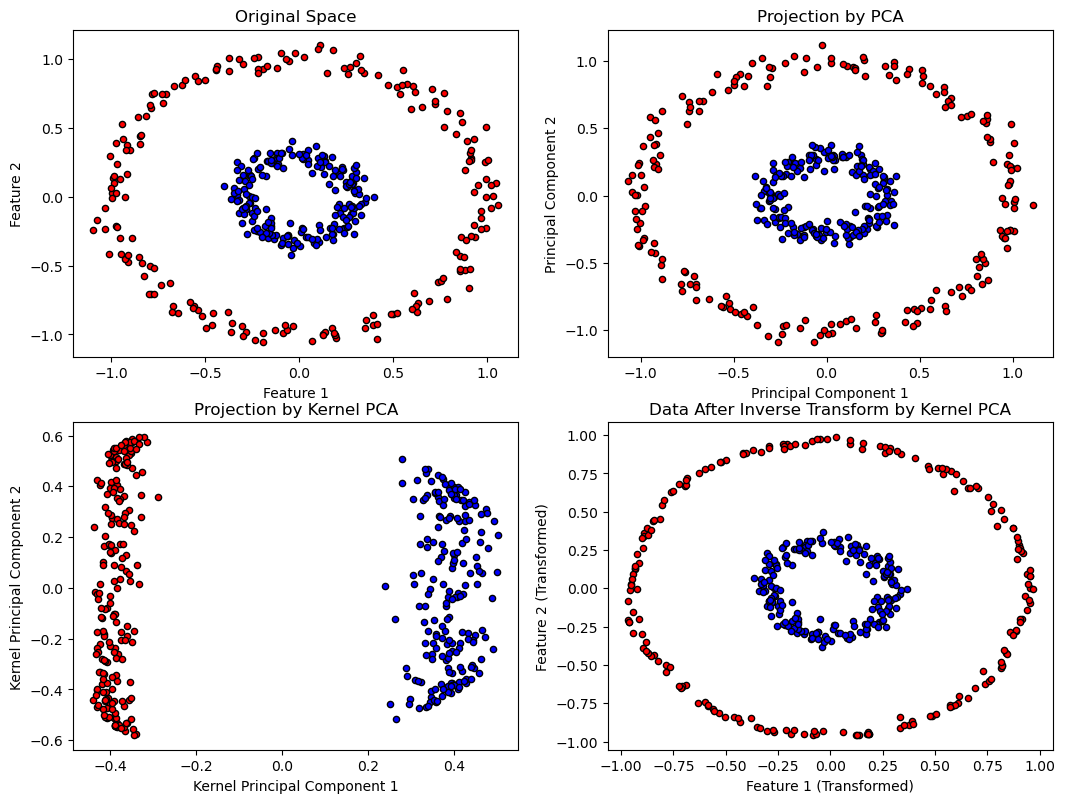

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

# Create a synthetic dataset
np.random.seed(0)
X, y = make_circles(n_samples=400, factor=.3, noise=.05)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Apply Kernel PCA with RBF Kernel
sigma = 0.5
gamma = 1/(2*sigma**2)
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=gamma)
X_kpca = kpca.fit_transform(X)
X_back = kpca.inverse_transform(X_kpca)

# Plot original data
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1, aspect='auto')
plt.title("Original Space")
reds = y == 0
blues = y == 1
plt.scatter(X[reds, 0], X[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue", s=20, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot projection by PCA
plt.subplot(2, 2, 2, aspect='auto')
plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Projection by PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot projection by Kernel PCA
plt.subplot(2, 2, 3, aspect='auto')
plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Projection by Kernel PCA")
plt.xlabel("Kernel Principal Component 1")
plt.ylabel("Kernel Principal Component 2")

# Plot data after inverse transform by Kernel PCA
plt.subplot(2, 2, 4, aspect='auto')
plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red", s=20, edgecolor='k')
plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue", s=20, edgecolor='k')
plt.title("Data After Inverse Transform by Kernel PCA")
plt.xlabel("Feature 1 (Transformed)")
plt.ylabel("Feature 2 (Transformed)")

plt.subplots_adjust(0.02, 0., 1, 1.2, 0.2, 0.2)  # Increased wspace to 0.55
plt.show()

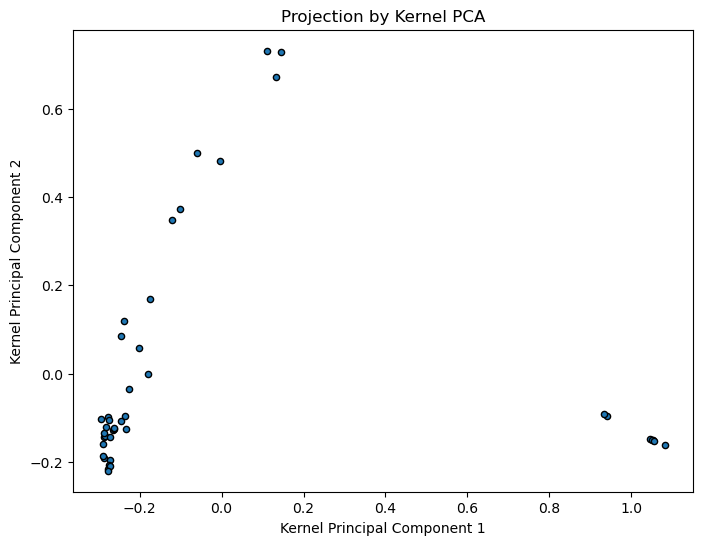

In [137]:
struct_name = '1AKEA'
mm = pdbparser(struct_name+'_mm.pdb',CA_only=True, output_gaps = True, mean_coords = True, trim_column1=True, output_chains_names=True, output_seqs=False)
gaps_mm = mm['gaps']
coords_mm = mm['coords']
sigma = 15
gamma = 1/(2*sigma**2)

kpca = KernelPCA(n_components=2,kernel="rbf", fit_inverse_transform=True, gamma=gamma,alpha=1e-9)

X_kpca = kpca.fit_transform(coords_mm)

plt.figure(figsize=(8,6))
plt.scatter(X_kpca[:, 0], X_kpca[:, 1], s=20, edgecolor='k')
plt.title("Projection by Kernel PCA")
plt.xlabel("Kernel Principal Component 1")
plt.ylabel("Kernel Principal Component 2")
plt.show()


In [145]:
### Here the idea is to interpolate along a principal component,
### and observe the trajectory in pymol.

k = 2 #Select a rank of reconstruction
j = 0 # number of the principal component to explore
nb_frames = 30 # number of frames to generate in the movie

kpca = KernelPCA(n_components=k,kernel="rbf", fit_inverse_transform=True, gamma=0.001,alpha=1e-9)

X_kpca = kpca.fit_transform(coords_mm)

trajectory = np.zeros((k,nb_frames))
trajectory[j,:] = np.linspace(X_kpca[:,j].min(),X_kpca[:,j].max(), nb_frames)

X_back = kpca.inverse_transform(trajectory.T)
write_struct(X_back,struct_name+f'_mm_traj_mode_{j}_kpca.pdb')


In [147]:
X_back.shape

(30, 645)

In [149]:
coords_mm.shape

(42, 645)










### **(Very) short introduction to neural networks:**


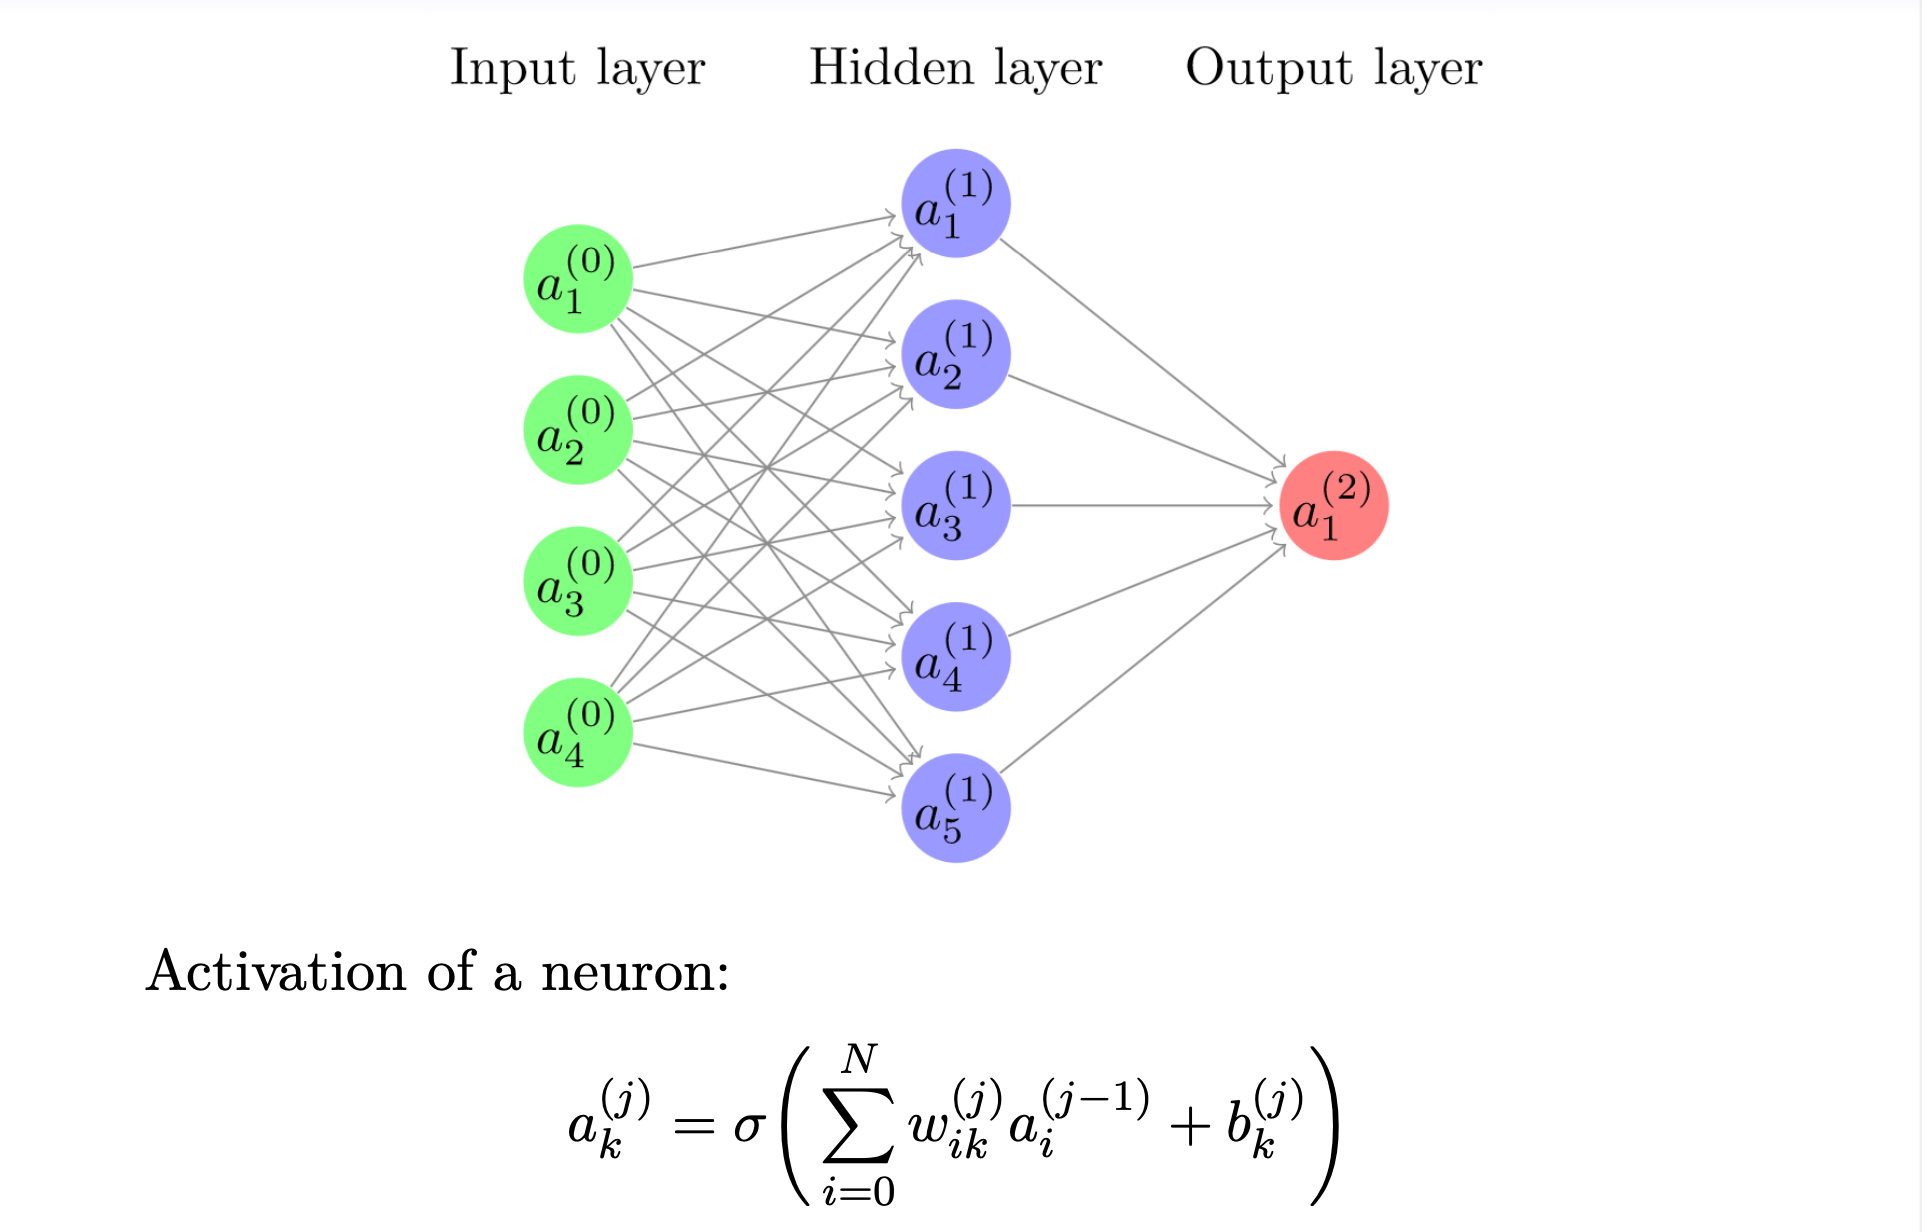

In [150]:
Image("NN1.png",width = 700)

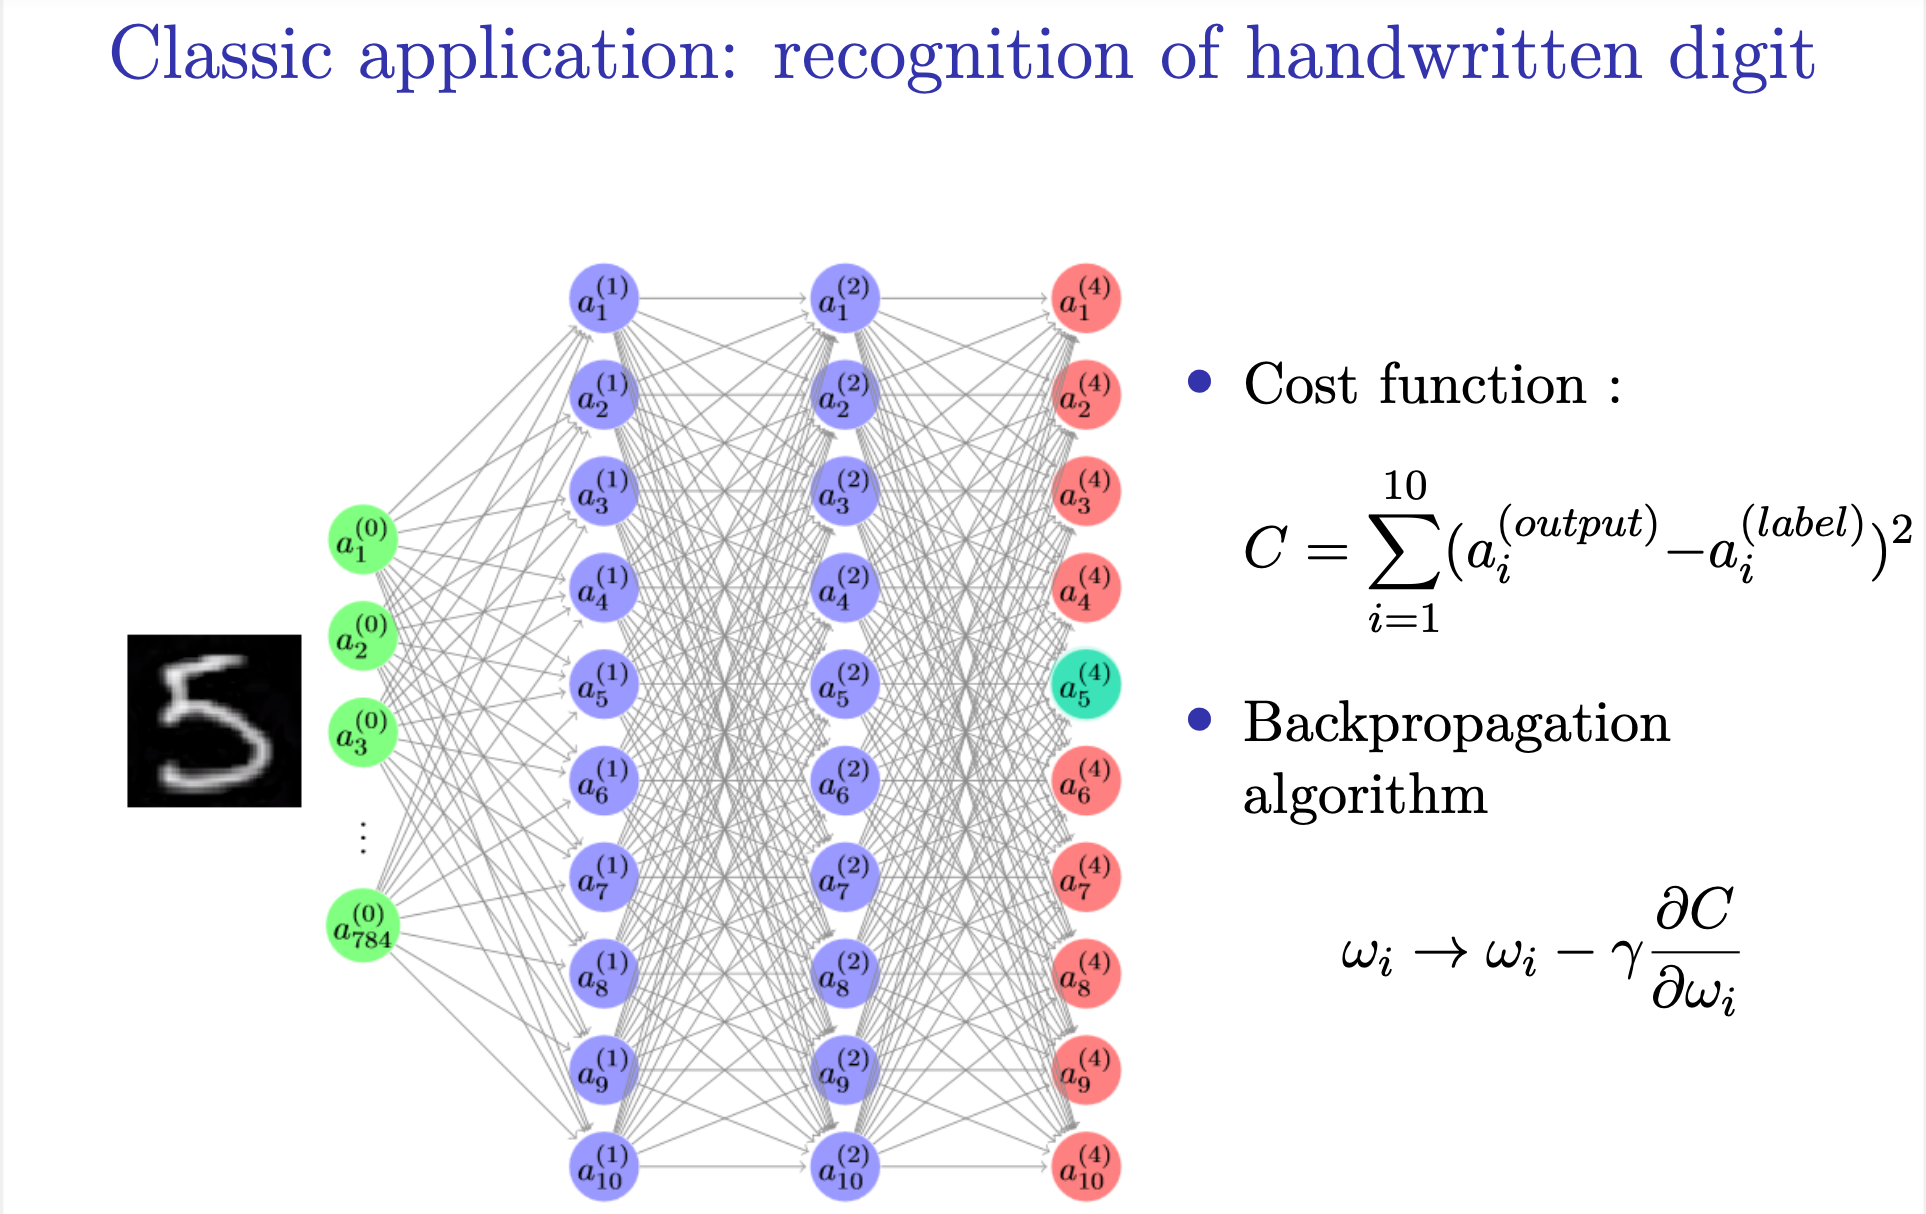

In [151]:
Image("NN2.png",width = 700)

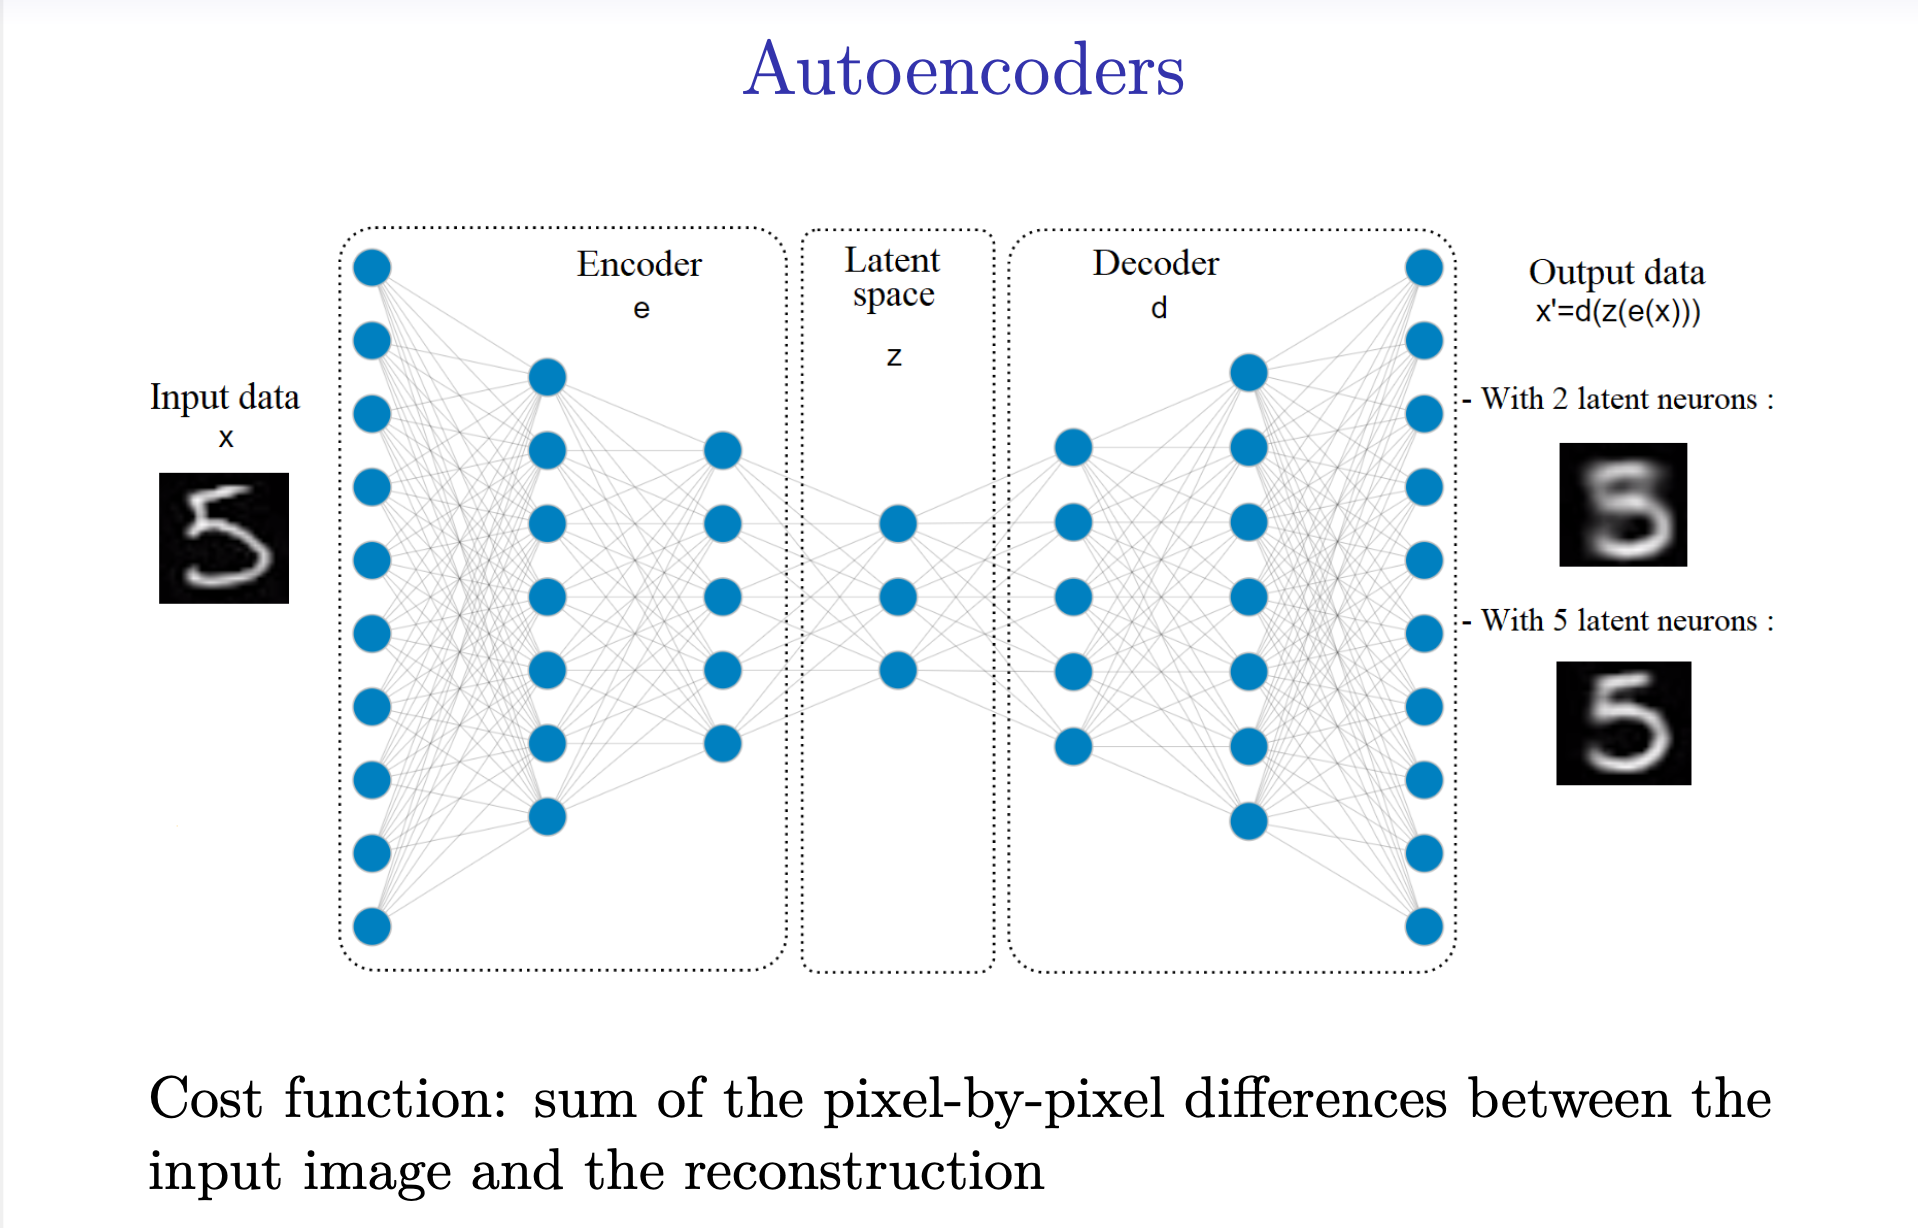

In [152]:
Image("NN3.png",width=700)

In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 422.8/906.5 MB 265.4 kB/s eta 0:30:23
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/opt/conda/lib/python3.11/site-packages/pip/_vendor/urllib3/response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/pip/_vendor/urllib3/response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
           ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/http/client.py", line 466, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/ssl.py", line 1311, in recv_into
    return self.read(nbytes, b

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size / 10)),
            nn.ReLU(),
            nn.Linear(int(input_size / 10), encoding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, int(input_size/10)),
            nn.ReLU(),
            nn.Linear(int(input_size / 10), input_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train_autoencoder(input_size, encoding_dim, learning_rate, num_epochs, input_data):
    model = SimpleAutoencoder(input_size, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    input_data = torch.Tensor(input_data)
    losses = []
    for epoch in tqdm(range(num_epochs)):
        # forward
        output = model(input_data)
        loss = criterion(output, input_data)
        losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.plot(losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    return model




ModuleNotFoundError: No module named 'torch'

In [ ]:
print(coords_mm.shape)
input_size = coords_mm.shape[1]

encoding_dim = 2 # Dimension of the latent space (2 is good for visualization)
learning_rate = 0.001
num_epochs = 500
norm_coord_mm = coords_mm-np.mean(coords_mm, axis=0)
model = train_autoencoder(input_size, encoding_dim, learning_rate, num_epochs, norm_coord_mm)

In [ ]:
def extract_latent_representation(model, input_data):
    with torch.no_grad():
        input_data = torch.Tensor(input_data)
        latent_representation = model.encoder(input_data)
    return latent_representation.numpy()

latent_representations = extract_latent_representation(model, coords_mm-np.mean(coords_mm, axis=0))

plt.figure(figsize=(10, 7))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.5)
plt.title('Latent Space Representation')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
with torch.no_grad():
    input_data = torch.Tensor(norm_coord_mm)
    latent_representations = model.encoder(input_data)
    min_val = torch.min(latent_representations)
    max_val = torch.max(latent_representations)

# Sample a trajectory inside the latent space of the autoencoder and decode it as a trajectory inside the 3D space
num_samples = 30
samples = np.zeros((2,30))
samples[0,:] = np.linspace(#####,#####,num_samples)
samples[1,:] = np.linspace(######,######,num_samples)
samples = torch.Tensor(samples)

with torch.no_grad():
    reconstructed_samples = model.decoder(samples.T)


reconstructed_samples = reconstructed_samples.numpy()
reconstructed_samples = reconstructed_samples + np.mean(coords_mm, axis=0)
print(reconstructed_samples.shape)
write_struct(reconstructed_samples,struct_name+f'_mm_traj_autoencoder.pdb')

In [ ]:

num_samples = 60
r = 10  # radius, can be adjusted
theta = np.linspace(0, 2 * np.pi, num_samples)

# assuming the center of the circle is at (x_center, y_center)
x_center, y_center = -7.5, 0  # can be adjusted

x = r * np.cos(theta) + x_center
y = r * np.sin(theta) + y_center

samples = np.vstack((x, y))
samples = torch.Tensor(samples)

with torch.no_grad():
    reconstructed_samples = model.decoder(samples.T)

reconstructed_samples = reconstructed_samples.numpy()
reconstructed_samples = reconstructed_samples + np.mean(coords_mm, axis=0)
print(reconstructed_samples.shape)
write_struct(reconstructed_samples, struct_name + '_mm_traj_circle_autoencoder.pdb')

# VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

class BetaVariationalAutoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(BetaVariationalAutoencoder, self).__init__()

        # Encoder: learn both mean and log variance
        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size / 10)),
            nn.ReLU(),
            nn.Linear(int(input_size / 10), encoding_dim * 2)  # 2 * encoding_dim for mean and log_var
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, int(input_size / 10)),
            nn.ReLU(),
            nn.Linear(int(input_size / 10), input_size)
        )

    def reparametrize(self, mean, log_var):
        """Reparameterization trick: z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)  # random noise
        return mean + eps * std

    def forward(self, x):
        # Encode to get the mean and log variance
        encoded = self.encoder(x)
        mean, log_var = torch.chunk(encoded, 2, dim=1)  # Split into mean and log variance

        # Reparameterization trick
        z = self.reparametrize(mean, log_var)

        # Decode
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var

def beta_vae_loss(reconstructed, original, mean, log_var, beta):
    """Beta-VAE loss: reconstruction loss + beta-scaled KL divergence"""

    # Reconstruction loss
    recon_loss = nn.functional.mse_loss(reconstructed, original, reduction='mean')

    # KL divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # Beta-VAE loss: reconstruction loss + beta * KL divergence
    return recon_loss + beta * kl_divergence

def train_beta_variational_autoencoder(input_size, encoding_dim, learning_rate, num_epochs, input_data, beta=1.0):
    model = BetaVariationalAutoencoder(input_size, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    input_data = torch.Tensor(input_data)
    losses = []

    for epoch in tqdm(range(num_epochs)):
        # forward
        reconstructed, mean, log_var = model(input_data)
        loss = beta_vae_loss(reconstructed, input_data, mean, log_var, beta)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot the loss curve
    plt.plot(losses)
    plt.title('Training Loss Curve (Beta-VAE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    return model

In [ ]:
print(coords_mm.shape)
input_size = coords_mm.shape[1]

encoding_dim = 2  # Dimension of the latent space (2 is good for visualization)
learning_rate = 0.001
num_epochs = 300
beta = 0.01  # You can adjust the beta value to control KL divergence weight

norm_coord_mm = coords_mm - np.mean(coords_mm, axis=0)

# Training the Beta-VAE
model = train_beta_variational_autoencoder(input_size, encoding_dim, learning_rate, num_epochs, norm_coord_mm, beta)

In [ ]:
def extract_latent_representation_vae(model, input_data):
    with torch.no_grad():
        input_data = torch.Tensor(input_data)
        encoded = model.encoder(input_data)
        mean, log_var = torch.chunk(encoded, 2, dim=1)
        # Mean as latent representation
        latent_representation = mean
    return latent_representation.numpy()

# Extraction de la représentation latente avec le modèle VAE
latent_representations = extract_latent_representation_vae(model, coords_mm - np.mean(coords_mm, axis=0))

# Visualisation de l'espace latent
plt.figure(figsize=(10, 7))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.5)
plt.title('Latent Space Representation (VAE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:

num_samples = 30
samples = np.zeros((2, num_samples))
samples[0, :] = np.linspace(-0.5, 2, num_samples)  # First axis sampling
samples[1, :] = np.linspace(0.5, -1.5, num_samples)  # Second axis sampling
samples = torch.Tensor(samples)

with torch.no_grad():
    reconstructed_samples = model.decoder(samples.T)  # Decoding the latent samples

reconstructed_samples = reconstructed_samples.numpy()
reconstructed_samples = reconstructed_samples + np.mean(coords_mm, axis=0)

print(reconstructed_samples.shape)

write_struct(reconstructed_samples, struct_name + f'_mm_traj_VAE.pdb')